## Meta-Learning with the Rank-Weighted GP Ensemble (RGPE)

BoTorch is designed in to be model-agnostic and only requries that a model conform to a minimal interface. This tutorial walks through an example of implementing the rank-weighted Gaussian process ensemble (RGPE) [Feurer, Letham, Bakshy ICML 2018 AutoML Workshop] and using the RGPE in BoTorch to do meta-learning across related optimization tasks.

* Original paper: https://arxiv.org/pdf/1802.02219.pdf

In [1]:
import os
import torch
import math


torch.manual_seed(29)
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
dtype = torch.double
SMOKE_TEST = os.environ.get("SMOKE_TEST")

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from botorch.models import SingleTaskGP, ModelListGP
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch.utils.multi_objective.scalarization import get_chebyshev_scalarization
from botorch import fit_gpytorch_model
from botorch.optim.optimize import optimize_acqf_list
from botorch.utils.transforms import unnormalize, normalize
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement
from botorch.utils.sampling import sample_simplex
from botorch.acquisition.objective import GenericMCObjective
from botorch.sampling import IIDNormalSampler
from botorch.sampling.samplers import SobolQMCNormalSampler

### Toy Problem
* We consider optimizing the following 1-D synthetic function
$$f(x, s_i) = \frac{1}{10}\bigg(x-1\bigg)\bigg(\sin(x+s_i)+\frac{1}{10}\bigg)$$
where
$$s_i = \frac{(i+9)\pi}{8}$$
is a task-dependent shift parameter and $i$ is the task index $i \in [1, t]$.

* In this tutorial, we will consider the scenario where we have collected data from 5 prior tasks (referred to as base tasks), which with a different task dependent shift parameter $s_i$.

* The goal now is use meta-learning to improve sample efficiency when optimizing a 6th task.

#### Toy Problem Setup

First let's define a function for compute the shift parameter $s_i$ and set the shift amount for the target task.

In [17]:
NUM_BASE_TASKS = 4 if not SMOKE_TEST else 2


def task_shift(task):
    """
    Fetch shift amount for task.
    """
    return math.pi * task / 12.0


# set shift for target task

# TARGET_SHIFT = 0.0 # (for default Alpine function)
TARGET_SHIFT = 1.0 # (for Schaffer and others)

Then, let's define our function $f(x, s_i)$ and set bounds on $x$.

In [18]:
# BOUNDS = torch.tensor([[-10], [10.0]], dtype=dtype, device=device) # For default Alpine function
BOUNDS = torch.tensor([[0], [2.0]], dtype=dtype, device=device) # For Schaffer
# BOUNDS = torch.tensor([[0], [1.0]], dtype=dtype, device=device) # For ZDT1

def f(X, shift=TARGET_SHIFT):
    """
    Torch-compatible multi-objective function for the target_task
    """
    # f1 = X * torch.sin(X + torch.pi + shift) + X / 10.0
    # f2 = X * torch.cos(X + torch.pi + shift) - X / 5.0
    
    # # Schaffer
    f1 = -(shift*X)**2
    f2 = -(shift*X - 2)**2

    # ZDT1
    g = 1.0
    h = 1.0 - shift*np.sqrt(X / g)
    f1 = shift*X + 0.3*np.sin(5 * np.pi * X)
    f2 = g * h + 0.3*np.cos(5 * np.pi * X)

    # f1 = -(3*(shift*X)**2 + 4*(shift*X) + 10)

    # f2 = -(5*(shift*X)**2 - 3*(shift*X) - 5)
    
    # f1 = -(X * shift)
    # f2 = -(1 - np.sqrt(X * shift))

    f_X = torch.cat([f1, f2], dim=-1)   # Stack the objectives along the last dimension
    return f_X

In [114]:
# Testing...

# x = torch.linspace(BOUNDS[0][0], BOUNDS[1][0], 100).unsqueeze(-1)
 
# y=f(x,0)


# print(y.shape)
# y

In [113]:
# y[:,0] # objective 1
# y[:,1] # objective 2

In [111]:
# x
# x.shape

In [112]:
# noise_std = 0.05
# y_new = y + noise_std * torch.randn_like(y) ## values with Gaussian noise
# yvar = torch.full_like(y, noise_std**2) ## variance of noise

In [110]:
# # If using different noise levels

# y_new[:,0] = y[:,0] + 0.07*torch.randn_like(y[:,0])
# y_new[:,1] = y[:,1] + 0.05*torch.randn_like(y[:,1])
# yvar[:,0] = torch.full_like(y[:,0], 0.07**2)
# yvar[:,1] = torch.full_like(y[:,1], 0.05**2)

In [109]:
# y_new

#### Sample training data for prior base tasks

We sample data from a Sobol sequence to help ensure numerical stability when using a small amount of 1-D data. Sobol sequences help prevent us from sampling a bunch of training points that are close together.

In [19]:
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.transforms import normalize, unnormalize

# noise_std = 0.05

# # Sample data for each base task
# data_by_task = {}
# for task in range(NUM_BASE_TASKS):
#     num_training_points = 20
#     # draw points from a sobol sequence
#     raw_x = draw_sobol_samples(
#         bounds=BOUNDS,
#         n=num_training_points,
#         q=1,
#         seed=task + 5397923,
#     ).squeeze(1)
#     # get observed values
#     f_x = f(raw_x, task_shift(task + 1))
#     train_y = f_x + noise_std * torch.randn_like(f_x)
#     train_yvar = torch.full_like(train_y, noise_std**2)
#     # store training data
#     data_by_task[task] = {
#     # scale x to [0, 1]
#     "train_x": normalize(raw_x, bounds=BOUNDS),
#     # "train_x": raw_x,
#     "train_y": train_y,
#     "train_yvar": train_yvar,
#     }


# Schaffer function

noise_std = 0.05
shift_values = [1.2, 1.4, 1.6, 1.8]
# Sample data for each base task
data_by_task = {}
for task in range(NUM_BASE_TASKS):
    num_training_points = 20
    # draw points from a sobol sequence
    raw_x = draw_sobol_samples(
        bounds=BOUNDS,
        n=num_training_points,
        q=1,
        seed=task + 5397923,
    ).squeeze(1)
    # get observed values
    f_x = f(raw_x, shift_values[task])
    train_y = f_x + noise_std * torch.randn_like(f_x)
    train_yvar = torch.full_like(train_y, noise_std**2)
    # store training data
    data_by_task[task] = {
    # scale x to [0, 1]
    # "train_x": normalize(raw_x, bounds=BOUNDS),
    "train_x": raw_x,
    "train_y": train_y,
    "train_yvar": train_yvar,
    }

In [20]:
data_by_task[0]
# data_by_task[1]
# data_by_task[2]
# data_by_task[3]

{'train_x': tensor([[0.9462],
         [1.5027],
         [1.4206],
         [0.0983],
         [0.2796],
         [1.2073],
         [1.8673],
         [0.6741],
         [0.6240],
         [1.9269],
         [1.0248],
         [0.4565],
         [0.1656],
         [1.3472],
         [1.7031],
         [0.7557],
         [0.8301],
         [1.6485],
         [1.3012],
         [0.2485]], dtype=torch.float64),
 'train_y': tensor([[-1.2835e+00, -7.3379e-01],
         [-3.2499e+00,  4.1119e-03],
         [-2.9396e+00, -1.7821e-01],
         [-5.2082e-02, -3.5811e+00],
         [-1.0320e-01, -2.8384e+00],
         [-2.0809e+00, -3.2702e-01],
         [-4.9342e+00, -2.1168e-04],
         [-6.0458e-01, -1.4482e+00],
         [-5.9936e-01, -1.5590e+00],
         [-5.3454e+00, -1.7629e-01],
         [-1.5313e+00, -5.6262e-01],
         [-2.3511e-01, -2.0089e+00],
         [-3.5246e-02, -3.2280e+00],
         [-2.6451e+00, -1.3714e-01],
         [-4.1756e+00, -1.3741e-02],
         [-7.7523e-0

#### Let's plot the base tasks and the target task function along with the observed points

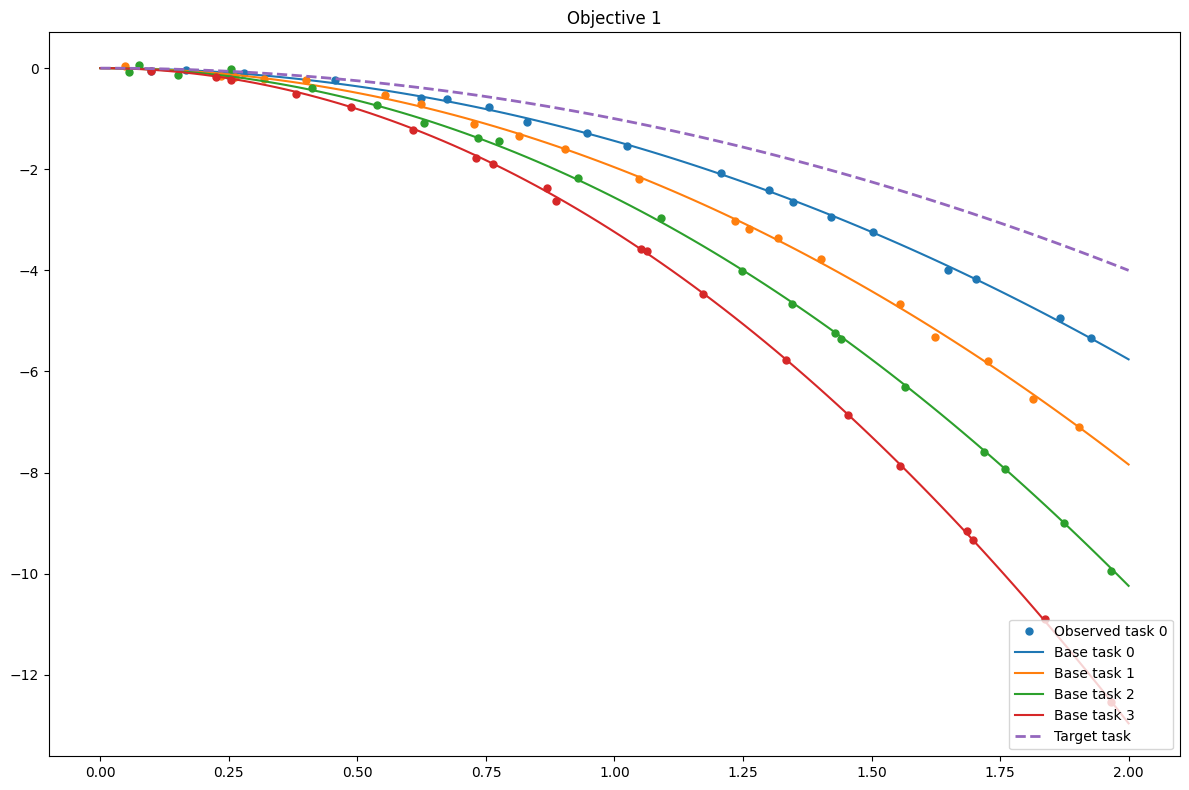

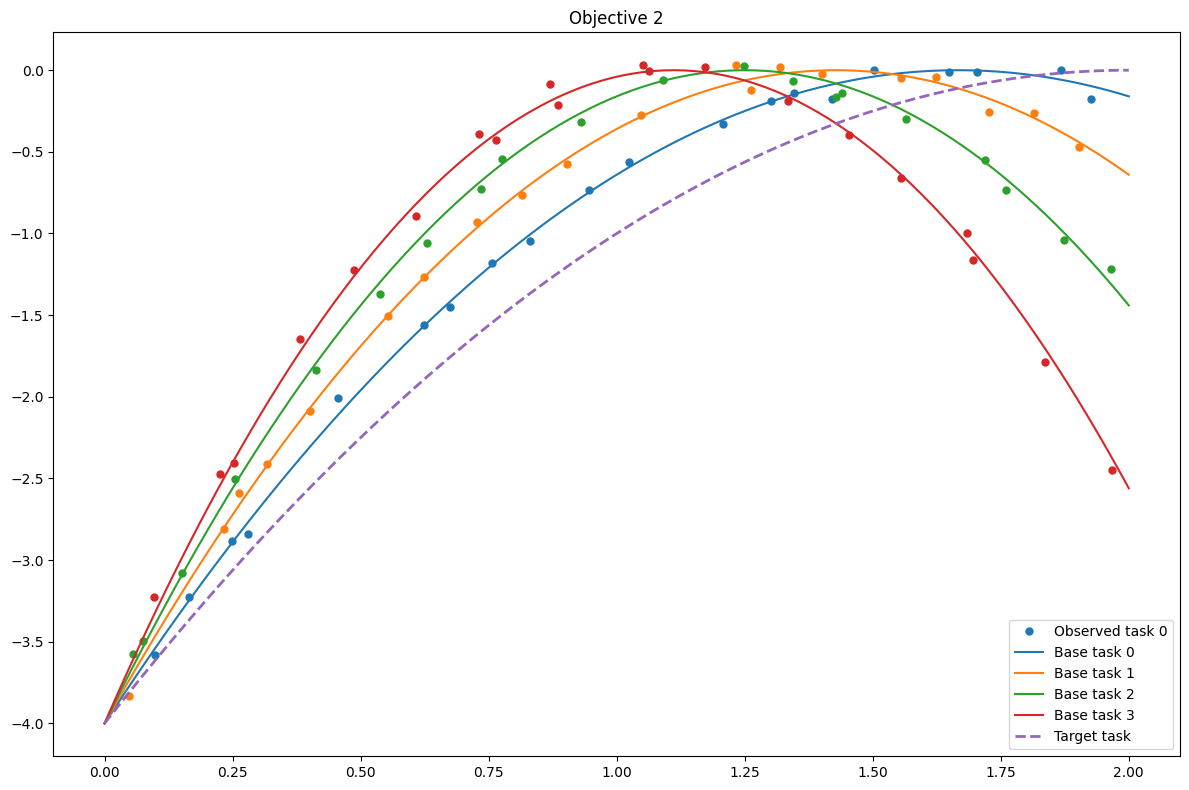

In [21]:
from matplotlib import pyplot as plt

# Plotting
x = torch.linspace(BOUNDS[0][0], BOUNDS[1][0], 100).unsqueeze(-1)

# for obj in range(2):
#     fig, ax = plt.subplots(1, 1, figsize=(12, 8))
#     for task in data_by_task:
#         # Plot observed values
#         t = ax.plot(
#             unnormalize(data_by_task[task]["train_x"], bounds=BOUNDS).cpu().numpy(),
#             # data_by_task[task]["train_x"].cpu().numpy(),
#             data_by_task[task]["train_y"][:, obj].cpu().numpy(),
#             ".",
#             markersize=10,
#             label=f"Observed task {task}" if task == 0 else "",
#         )
#         # Plot true function
#         ax.plot(
#             x.detach().numpy(),
#             f(x, task_shift(task + 1))[:, obj].cpu().numpy(),
#             label=f"Base task {task}",
#             color=t[0].get_color(),
#         )
#     # Plot true target function
#     ax.plot(
#         x.detach().numpy(),
#         f(x, TARGET_SHIFT)[:, obj].detach().numpy(),
#         "--",
#         label="Target task",
#         linewidth=2,
#     )
#     ax.set_title(f"Objective {obj + 1}")
#     ax.legend(loc="lower right", fontsize=10)
#     plt.tight_layout()
#     plt.show()

# Schaffer
# Plotting
x = torch.linspace(BOUNDS[0][0], BOUNDS[1][0], 100).unsqueeze(-1)

for obj in range(2):
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    for task in data_by_task:
        # Plot observed values
        t = ax.plot(
            # unnormalize(data_by_task[task]["train_x"], bounds=BOUNDS).cpu().numpy(),
            data_by_task[task]["train_x"].cpu().numpy(),
            data_by_task[task]["train_y"][:, obj].cpu().numpy(),
            ".",
            markersize=10,
            label=f"Observed task {task}" if task == 0 else "",
        )
        # Plot true function
        ax.plot(
            x.detach().numpy(),
            f(x, shift_values[task])[:, obj].cpu().numpy(),
            label=f"Base task {task}",
            color=t[0].get_color(),
        )
    # Plot true target function
    ax.plot(
        x.detach().numpy(),
        f(x, TARGET_SHIFT)[:, obj].detach().numpy(),
        "--",
        label="Target task",
        linewidth=2,
    )
    ax.set_title(f"Objective {obj + 1}")
    ax.legend(loc="lower right", fontsize=10)
    plt.tight_layout()
    plt.show()

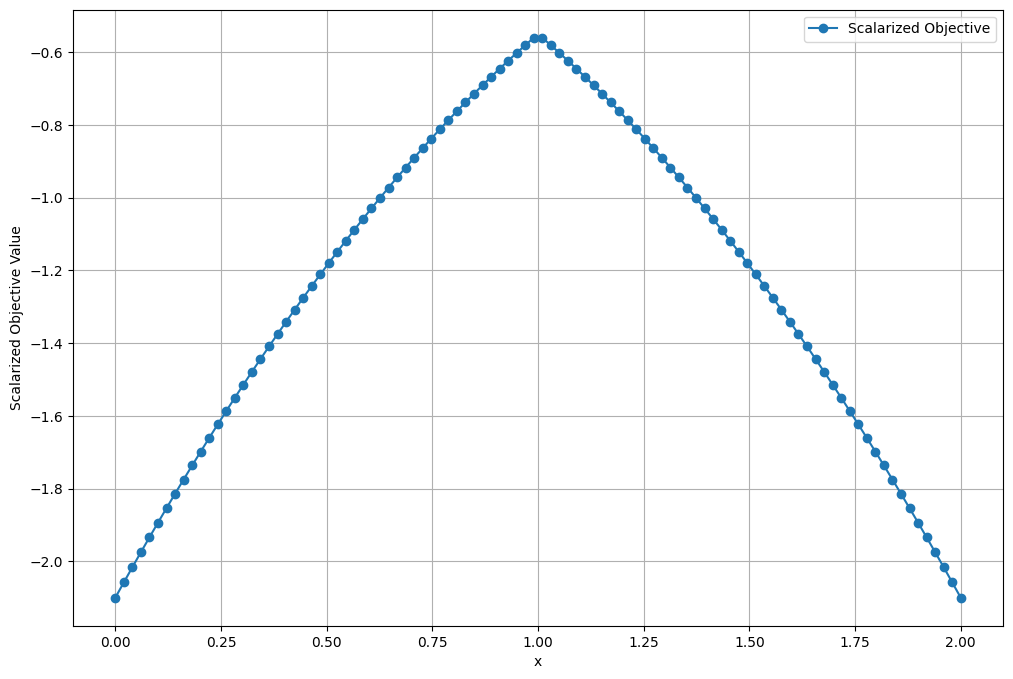

In [22]:
# Plot best observed scalarized value 

# Define the weights and alpha for the custom scalarization
weights = torch.tensor([0.5, 0.5])
alpha = 0.05

# Define the custom scalarization function with min and sum components
def custom_scalarization(x, weights, alpha=0.05):
    values = f(x) 
    # values = -f(x) # for minimization 
    weighted_values = weights * values
    return weighted_values.min(dim=-1).values + alpha * weighted_values.sum(dim=-1)
    # return weighted_values.sum(dim = -1)

scalarized_objective = np.array([custom_scalarization(xi, weights, alpha) for xi in x])


# Plot the scalarized objectives
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
plt.plot(x, scalarized_objective, label='Scalarized Objective', marker='o')
plt.xlabel('x')
plt.ylabel('Scalarized Objective Value')
plt.legend()
plt.grid(True)
plt.show()

### Fit base task models

First, let's define a helper function to fit a FixedNoiseGP with an fixed observed noise level.

In [23]:
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models import FixedNoiseGP
from botorch.fit import fit_gpytorch_mll


def get_fitted_model_SO(train_X, train_Y, train_Yvar, state_dict=None):
    """
    Get a single task GP. The model will be fit unless a state_dict with model
        hyperparameters is provided.
    """
    Y_mean = train_Y.mean(dim=-2, keepdim=True)
    Y_std = train_Y.std(dim=-2, keepdim=True)
    model = FixedNoiseGP(train_X, (train_Y - Y_mean) / Y_std, train_Yvar)
    # model = FixedNoiseGP(train_X, train_Y, train_Yvar)
    model.Y_mean = Y_mean
    model.Y_std = Y_std
    if state_dict is None:
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_mll(mll)
    else:
        model.load_state_dict(state_dict)
    return model

In [24]:
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models import FixedNoiseGP
from botorch.fit import fit_gpytorch_mll

# def get_fitted_model(train_x, train_y, train_Yvar, state_dict=None):
#     """
#     Get a single task GP. The model will be fit unless a state_dict with model
#         hyperparameters is provided.
#     """
#     # train_x = normalize(train_x, bounds)
#     models = []
#     for i in range(train_y.shape[-1]):
#         train_objective = train_y[:, i]
#         train_Yvar_objective = train_Yvar[:,i]
#         models.append(
#             FixedNoiseGP(train_x, train_objective.unsqueeze(-1), train_Yvar_objective.unsqueeze(-1))
#         )
#     model = ModelListGP(*models)
#     mll = SumMarginalLogLikelihood(model.likelihood, model)
#     fit_gpytorch_model(mll)
#     return model


def get_fitted_model(train_x, train_y, train_Yvar, state_dict=None):
    """
    Get a multi-objective GP model with standardized train_y. 
    The model will be fit unless a state_dict with model hyperparameters is provided.
    """
    models = []
    
    for i in range(train_y.shape[-1]):
        train_objective = train_y[:, i]
        train_Yvar_objective = train_Yvar[:, i]
        
        # Standardize the training objective
        Y_mean = train_objective.mean(dim=-1, keepdim=True)
        Y_std = train_objective.std(dim=-1, keepdim=True)
        standardized_train_objective = (train_objective - Y_mean) / Y_std
        
        model = FixedNoiseGP(train_x, standardized_train_objective.unsqueeze(-1), train_Yvar_objective.unsqueeze(-1))
        
        # Store the mean and std for later unstandardization
        model.Y_mean = Y_mean
        model.Y_std = Y_std
        models.append(model)

    # Create a ModelListGP from the individual models
    model = ModelListGP(*models)
    
    if state_dict is None:
        mll = SumMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_model(mll)
    else:
        model.load_state_dict(state_dict)
    
    return model

#### Now let's fit a FixedNoiseGP for each base task

In [25]:
# Fit base model
base_model_list = []
for task in range(NUM_BASE_TASKS):
    print(f"Fitting base model {task}")
    model = get_fitted_model(
        data_by_task[task]["train_x"],
        data_by_task[task]["train_y"],
        data_by_task[task]["train_yvar"],
    )
    base_model_list.append(model)

Fitting base model 0
Fitting base model 1
Fitting base model 2
Fitting base model 3


In [26]:
print(base_model_list[0].models[1])

FixedNoiseGP(
  (likelihood): FixedNoiseGaussianLikelihood(
    (noise_covar): FixedGaussianNoise()
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): MaternKernel(
      (lengthscale_prior): GammaPrior()
      (raw_lengthscale_constraint): Positive()
      (distance_module): Distance()
    )
    (outputscale_prior): GammaPrior()
    (raw_outputscale_constraint): Positive()
  )
)


### Implement the RGPE

The main idea of the RGPE is to estimate the target function as weighted sum of the target model and the base models:
$$\bar f(\mathbf x | \mathcal D) =
\sum_{i=1}^{t} w_if^i(\mathbf x |\mathcal D_i)$$
Importantly, the ensemble model is also a GP:
$$\bar f(\mathbf x | \mathcal D) \sim \mathcal N\bigg(\sum_{i=1}^{t} w_i\mu_i(\mathbf x), \sum_{i=1}^{t}w_i^2\sigma_i^2\bigg)$$

The weights $w_i$ for model $i$ are based on the the ranking loss between a draw from the model's posterior and the targets. Specifically, the ranking loss for model $i$ is:
$$\mathcal L(f^i, \mathcal D_t) = \sum_{j=1}^{n_t}\sum_{k=1}^{n_t}\mathbb 1\bigg[\bigg(f^i\big(\mathbf x^t_j\big) < f^i\big(\mathbf x_k^t\big)\bigg)\oplus \big(y_j^t < y_k^t\big)\bigg]$$
where $\oplus$ is exclusive-or.

The loss for the target model is computing using leave-one-out cross-validation (LOOCV) and is given by:
$$\mathcal L(f^t, \mathcal D_t) = \sum_{j=1}^{n_t}\sum_{k=1}^{n_t}\mathbb 1\bigg[\bigg(f^t_{-j}\big(\mathbf x^t_j\big) < f^t_{-j}\big(\mathbf x_k^t\big)\bigg)\oplus \big(y_j^t < y_k^t\big)\bigg]$$
where $f^t_{-j}$ model fitted to all data from the target task except training example $j$.

The weights are then computed as:
$$w_i = \frac{1}{S}\sum_{s=1}^S\mathbb 1\big(i = \text{argmin}_{i'}l_{i', s}\big)$$

In [55]:
def roll_col(X, shift):
    """
    Rotate columns to right by shift.
    """
    return torch.cat((X[..., -shift:], X[..., :-shift]), dim=-1)

In [54]:
def compute_ranking_loss(f_samps, target_y):
    """
    Compute ranking loss for each sample from the posterior over target points.

    Args:
        f_samps: `n_samples x (n) x n`-dim tensor of samples
        target_y: `n x 1`-dim tensor of targets
    Returns:
        Tensor: `n_samples`-dim tensor containing the ranking loss across each sample
    """
    n = target_y.shape[0]
    if f_samps.ndim == 3:
        # Compute ranking loss for target model
        # take cartesian product of target_y
        cartesian_y = torch.cartesian_prod(
            target_y.squeeze(-1),
            target_y.squeeze(-1),
        ).view(n, n, 2)
        # the diagonal of f_samps are the out-of-sample predictions
        # for each LOO model, compare the out of sample predictions to each in-sample prediction
        rank_loss = (
            (
                (f_samps.diagonal(dim1=1, dim2=2).unsqueeze(-1) < f_samps)
                ^ (cartesian_y[..., 0] < cartesian_y[..., 1])
            )
            .sum(dim=-1)
            .sum(dim=-1)
        )
    else:
        rank_loss = torch.zeros(
            f_samps.shape[0], dtype=torch.long, device=target_y.device
        )
        y_stack = target_y.squeeze(-1).expand(f_samps.shape)
        for i in range(1, target_y.shape[0]):
            rank_loss += (
                (roll_col(f_samps, i) < f_samps) ^ (roll_col(y_stack, i) < y_stack)
            ).sum(dim=-1)
    return rank_loss

Define a function to:
1. Create a batch mode-gp LOOCV GP using the hyperparameters from `target_model`
2. Draw a joint sample across all points from the target task (in-sample and out-of-sample)

In [53]:
def get_target_model_loocv_sample_preds(
    train_x, train_y, train_yvar, target_model, num_samples
):
    """
    Create a batch-mode LOOCV GP and draw a joint sample across all points from the target task.

    Args:
        train_x: `n x d` tensor of training points
        train_y: `n x 1` tensor of training targets
        target_model: fitted target model
        num_samples: number of mc samples to draw

    Return: `num_samples x n x n`-dim tensor of samples, where dim=1 represents the `n` LOO models,
        and dim=2 represents the `n` training points.
    """
    batch_size = len(train_x)
    masks = torch.eye(len(train_x), dtype=torch.uint8, device=device).bool()
    train_x_cv = torch.stack([train_x[~m] for m in masks])
    train_y_cv = torch.stack([train_y[~m] for m in masks])
    train_yvar_cv = torch.stack([train_yvar[~m] for m in masks])
    state_dict = target_model.state_dict()
    # expand to batch size of batch_mode LOOCV model
    state_dict_expanded = {
        name: t.expand(batch_size, *[-1 for _ in range(t.ndim)])
        for name, t in state_dict.items()
    }
    model = get_fitted_model_SO(
        train_x_cv, train_y_cv, train_yvar_cv, state_dict=state_dict_expanded
    )
    with torch.no_grad():
        posterior = model.posterior(train_x)
        # Since we have a batch mode gp and model.posterior always returns an output dimension,
        # the output from `posterior.sample()` here `num_samples x n x n x 1`, so let's squeeze
        # the last dimension.
        sampler = SobolQMCNormalSampler(num_samples=512)
        return sampler(posterior).squeeze(-1)

In [52]:
def compute_rank_weights(train_x, train_y, train_yvar, base_models, target_model, num_samples):
    """
    Compute ranking weights for each base model and the target model (using
        LOOCV for the target model). Note: This implementation does not currently
        address weight dilution, since we only have a small number of base models.

    Args:
        train_x: `n x d` tensor of training points (for target task)
        train_y: `n` tensor of training targets (for target task)
        base_models: list of base models
        target_model: target model
        num_samples: number of mc samples

    Returns:
        Tensor: `n_t`-dim tensor with the ranking weight for each model
    """
    ranking_losses = []
    # compute ranking loss for each base model
    for task in range(len(base_models)):
        model = base_models[task]
        # compute posterior over training points for target task
        posterior = model.posterior(train_x)
        sampler = SobolQMCNormalSampler(num_samples=512)
        base_f_samps = sampler(posterior).squeeze(-1).squeeze(-1)
        # compute and save ranking loss
        ranking_losses.append(compute_ranking_loss(base_f_samps, train_y))
    # compute ranking loss for target model using LOOCV
    # f_samps
    target_f_samps = get_target_model_loocv_sample_preds(
        train_x,
        train_y,
        train_yvar,
        target_model,
        num_samples,
    )
    ranking_losses.append(compute_ranking_loss(target_f_samps, train_y))
    ranking_loss_tensor = torch.stack(ranking_losses)
    # compute best model (minimum ranking loss) for each sample
    best_models = torch.argmin(ranking_loss_tensor, dim=0)
    # compute proportion of samples for which each model is best
    rank_weights = (
        best_models.bincount(minlength=len(ranking_losses)).type_as(train_x)
        / num_samples
    )
    return rank_weights

In [56]:
from botorch.models.gpytorch import GPyTorchModel
from gpytorch.models import GP
from gpytorch.distributions import MultivariateNormal
from gpytorch.lazy import PsdSumLazyTensor
from gpytorch.likelihoods import LikelihoodList
from torch.nn import ModuleList


class RGPE(GP, GPyTorchModel):
    """
    Rank-weighted GP ensemble. Note: this class inherits from GPyTorchModel which provides an
        interface for GPyTorch models in botorch.
    """

    _num_outputs = 1  # metadata for botorch

    def __init__(self, models, weights):
        super().__init__()
        self.models = ModuleList(models)
        for m in models:
            if not hasattr(m, "likelihood"):
                raise ValueError(
                    "RGPE currently only supports models that have a likelihood (e.g. ExactGPs)"
                )
        self.likelihood = LikelihoodList(*[m.likelihood for m in models])
        self.weights = weights
        self.to(weights)

    def forward(self, x):
        weighted_means = []
        weighted_covars = []
        # filter model with zero weights
        # weights on covariance matrices are weight**2
        non_zero_weight_indices = (self.weights**2 > 0).nonzero()
        non_zero_weights = self.weights[non_zero_weight_indices]
        # re-normalize
        non_zero_weights /= non_zero_weights.sum()

        for non_zero_weight_idx in range(non_zero_weight_indices.shape[0]):
            raw_idx = non_zero_weight_indices[non_zero_weight_idx].item()
            model = self.models[raw_idx]
            posterior = model.posterior(x)
            # # unstandardize predictions
            posterior_mean = posterior.mean.squeeze(-1) * model.Y_std + model.Y_mean
            posterior_cov = posterior.mvn.lazy_covariance_matrix * model.Y_std.pow(2)
            # posterior_mean = posterior.mean.squeeze(-1)
            # posterior_cov = posterior.mvn.lazy_covariance_matrix
            
            # apply weight
            weight = non_zero_weights[non_zero_weight_idx]
            weighted_means.append(weight * posterior_mean)
            weighted_covars.append(posterior_cov * weight**2)
        # set mean and covariance to be the rank-weighted sum the means and covariances of the
        # base models and target model
        mean_x = torch.stack(weighted_means).sum(dim=0)
        covar_x = PsdSumLazyTensor(*weighted_covars)
        return MultivariateNormal(mean_x, covar_x)

In [57]:
from torch import Tensor
def get_chebyshev_scalarization_unnormalized(weights: Tensor, Y: Tensor, alpha: float = 0.05):
    r"""Construct an augmented Chebyshev scalarization.

    Augmented Chebyshev scalarization:
        objective(y) = min(w * y) + alpha * sum(w * y)

    Outcomes are first normalized to [0,1] for maximization (or [-1,0] for minimization)
    and then an augmented Chebyshev scalarization is applied.

    Note: this assumes maximization of the augmented Chebyshev scalarization.
    Minimizing/Maximizing an objective is supported by passing a negative/positive
    weight for that objective. To make all w * y's have positive sign
    such that they are comparable when computing min(w * y), outcomes of minimization
    objectives are shifted from [0,1] to [-1,0].

    See [Knowles2005]_ for details.

    This scalarization can be used with qExpectedImprovement to implement q-ParEGO
    as proposed in [Daulton2020qehvi]_.

    Args:
        weights: A `m`-dim tensor of weights.
            Positive for maximization and negative for minimization.
        Y: A `n x m`-dim tensor of observed outcomes, which are used for
            scaling the outcomes to [0,1] or [-1,0].
        alpha: Parameter governing the influence of the weighted sum term. The
            default value comes from [Knowles2005]_.

    Returns:
        Transform function using the objective weights.

    Example:
        >>> weights = torch.tensor([0.75, -0.25])
        >>> transform = get_aug_chebyshev_scalarization(weights, Y)
    """
    if weights.shape != Y.shape[-1:]:
        raise BotorchTensorDimensionError(
            "weights must be an `m`-dim tensor where Y is `... x m`."
            f"Got shapes {weights.shape} and {Y.shape}."
        )
    elif Y.ndim > 2:
        raise NotImplementedError("Batched Y is not currently supported.")

   # def chebyshev_obj(Y: Tensor, X: Optional[Tensor] = None) -> Tensor:
    def chebyshev_obj(Y: Tensor) -> Tensor:
        product = weights * Y
        return product.min(dim=-1).values + alpha * product.sum(dim=-1)

    if Y.shape[-2] == 0:
        # If there are no observations, we do not need to normalize the objectives
        return chebyshev_obj
    if Y.shape[-2] == 1:
        # If there is only one observation, set the bounds to be
        # [min(Y_m), min(Y_m) + 1] for each objective m. This ensures we do not
        # divide by zero
        Y_bounds = torch.cat([Y, Y + 1], dim=0)
    else:
        # Set the bounds to be [min(Y_m), max(Y_m)], for each objective m
        Y_bounds = torch.stack([Y.min(dim=-2).values, Y.max(dim=-2).values])

    # A boolean mask indicating if minimizing an objective
    minimize = weights < 0

    # def obj(Y: Tensor, X: Optional[Tensor] = None) -> Tensor:
    def obj(Y: Tensor) -> Tensor:
        # scale to [0,1]
        # Y_normalized = normalize(Y, bounds=Y_bounds)
        # # If minimizing an objective, convert Y_normalized values to [-1,0],
        # # such that min(w*y) makes sense, we want all w*y's to be positive
        # Y_normalized[..., minimize] = Y_normalized[..., minimize] - 1
        return chebyshev_obj(Y=Y)

    return obj

In [58]:
def get_weighted_sum(weights: Tensor, Y: Tensor):
    r"""Construct an augmented Chebyshev scalarization.

    Augmented Chebyshev scalarization:
        objective(y) = min(w * y) + alpha * sum(w * y)

    Outcomes are first normalized to [0,1] for maximization (or [-1,0] for minimization)
    and then an augmented Chebyshev scalarization is applied.

    Note: this assumes maximization of the augmented Chebyshev scalarization.
    Minimizing/Maximizing an objective is supported by passing a negative/positive
    weight for that objective. To make all w * y's have positive sign
    such that they are comparable when computing min(w * y), outcomes of minimization
    objectives are shifted from [0,1] to [-1,0].

    See [Knowles2005]_ for details.

    This scalarization can be used with qExpectedImprovement to implement q-ParEGO
    as proposed in [Daulton2020qehvi]_.

    Args:
        weights: A `m`-dim tensor of weights.
            Positive for maximization and negative for minimization.
        Y: A `n x m`-dim tensor of observed outcomes, which are used for
            scaling the outcomes to [0,1] or [-1,0].
        alpha: Parameter governing the influence of the weighted sum term. The
            default value comes from [Knowles2005]_.

    Returns:
        Transform function using the objective weights.

    Example:
        >>> weights = torch.tensor([0.75, -0.25])
        >>> transform = get_aug_chebyshev_scalarization(weights, Y)
    """
    if weights.shape != Y.shape[-1:]:
        raise BotorchTensorDimensionError(
            "weights must be an `m`-dim tensor where Y is `... x m`."
            f"Got shapes {weights.shape} and {Y.shape}."
        )
    elif Y.ndim > 2:
        raise NotImplementedError("Batched Y is not currently supported.")

    def chebyshev_obj(Y: Tensor) -> Tensor:
        product = weights * Y
        # return product.min(dim=-1).values + alpha * product.sum(dim=-1)
        return product.sum(dim=-1)
    if Y.shape[-2] == 0:
        # If there are no observations, we do not need to normalize the objectives
        return chebyshev_obj
    if Y.shape[-2] == 1:
        # If there is only one observation, set the bounds to be
        # [min(Y_m), min(Y_m) + 1] for each objective m. This ensures we do not
        # divide by zero
        Y_bounds = torch.cat([Y, Y + 1], dim=0)
    else:
        # Set the bounds to be [min(Y_m), max(Y_m)], for each objective m
        Y_bounds = torch.stack([Y.min(dim=-2).values, Y.max(dim=-2).values])

    # A boolean mask indicating if minimizing an objective
    minimize = weights < 0

    def obj(Y: Tensor) -> Tensor:
        # scale to [0,1]
        Y_normalized = normalize(Y, bounds=Y_bounds)
        # If minimizing an objective, convert Y_normalized values to [-1,0],
        # such that min(w*y) makes sense, we want all w*y's to be positive
        Y_normalized[..., minimize] = Y_normalized[..., minimize] - 1
        return chebyshev_obj(Y=Y_normalized)

    return obj


In [38]:
pip show botorch

Name: botorch
Version: 0.7.2
Summary: Bayesian Optimization in PyTorch
Home-page: https://botorch.org
Author: Facebook, Inc.
Author-email: 
License: MIT
Location: c:\Users\visha\AppData\Local\Programs\Python\Python312\Lib\site-packages
Requires: gpytorch, linear-operator, multipledispatch, pyro-ppl, scipy, torch
Required-by: 
Note: you may need to restart the kernel to use updated packages.


### Optimize target function using RGPE + qNEI

In [63]:
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement
#from botorch.acquisition.objective import ChebyshevScalarization
from botorch.utils.multi_objective.scalarization import get_chebyshev_scalarization
from botorch.models import ModelListGP, SingleTaskGP
from botorch.sampling import SobolQMCNormalSampler
from botorch.sampling import IIDNormalSampler
from botorch.optim.optimize import optimize_acqf
from botorch.utils.transforms import normalize, unnormalize
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.sampling import sample_simplex
from botorch.acquisition.objective import GenericMCObjective
import torch
import warnings

# suppress GPyTorch warnings about adding jitter
import warnings


warnings.filterwarnings("ignore", "^.*jitter.*", category=RuntimeWarning)


# Subscripts _1 and _2 represent objectives 1 and 2 respectively

best_rgpe_all_1 = []
best_rgpe_all_2 = []
best_vanilla_nei_all_1 = []
best_vanilla_nei_all_2 = []
rank_weights_all_1 = []
rank_weights_all_2 = []

N_BATCH = 10 if not SMOKE_TEST else 2
NUM_POSTERIOR_SAMPLES = 256 if not SMOKE_TEST else 16
RANDOM_INITIALIZATION_SIZE = 3
N_TRIALS = 8 # 10 if not SMOKE_TEST else 2
MC_SAMPLES = 512 if not SMOKE_TEST else 32
N_RESTART_CANDIDATES = 512 if not SMOKE_TEST else 8
N_RESTARTS = 10 if not SMOKE_TEST else 2
Q_BATCH_SIZE = 1


# Average over multiple trials
for trial in range(N_TRIALS):
    print(f"Trial {trial + 1} of {N_TRIALS}")
    best_rgpe_1 = []
    best_rgpe_2 = []
    best_vanilla_nei_1 = []
    best_vanilla_nei_2 = []
    rank_weights_list_1 = []
    rank_weights_list_2 = []
    
    # Initial random observations
    raw_x = draw_sobol_samples(bounds=BOUNDS, n=RANDOM_INITIALIZATION_SIZE, q=1, seed=0) #.squeeze(1)
    train_x = normalize(raw_x, bounds=BOUNDS)
    train_y_noiseless = f(raw_x)
    
    # reshape train_x and train_y
    train_x = train_x.view(train_x.shape[0],1)
    train_y_noiseless = train_y_noiseless.view(train_y_noiseless.shape[0],2)  # where 2 is the number of objectives
    
    train_y = train_y_noiseless + noise_std * torch.randn_like(train_y_noiseless)
    train_yvar = torch.full_like(train_y, noise_std**2)
    train_yvar = train_yvar.view(train_yvar.shape[0],2) # where 2 is the number of objectives

    # clone train_x and train_y for vanilla (regular GP)
    vanilla_nei_train_x = train_x.clone()
    vanilla_nei_train_y = train_y.clone()
    vanilla_nei_train_yvar = train_yvar.clone()
    
    # # keep track of the best observed point at each iteration
    # best_value_1 = train_y[:,0].max().item()
    # best_value_2 = train_y[:,1].max().item()
    # best_rgpe_1.append(best_value_1)
    # best_rgpe_2.append(best_value_2)


    # Run N_BATCH rounds of BayesOpt after the initial random batch
    for iteration in range(N_BATCH):
        target_model = get_fitted_model(train_x, train_y, train_yvar)

        # hard coded indices - needs to be improved later
        # base_model_list_1 =[base_model_list[0].models[0],base_model_list[1].models[0], base_model_list[2].models[0], base_model_list[3].models[0], base_model_list[4].models[0]]
        # base_model_list_2 = [base_model_list[0].models[1],base_model_list[1].models[1], base_model_list[2].models[1], base_model_list[3].models[1], base_model_list[4].models[1]]
        base_model_list_1 = [base_model_list[i].models[0] for i in range(NUM_BASE_TASKS)]
        base_model_list_2 = [base_model_list[i].models[1] for i in range(NUM_BASE_TASKS)]

        
        target_model_1 = target_model.models[0]
        target_model_2 = target_model.models[1]
            
        model_list_1 = base_model_list_1 + [target_model_1]
        model_list_2 = base_model_list_2 + [target_model_2]
        
        train_y_1 = train_y[:,0].reshape(train_y.shape[0],1)
        train_yvar_1 = train_yvar[:,0].reshape(train_yvar.shape[0],1)
        
        train_y_2 = train_y[:,1].reshape(train_y.shape[0],1)
        train_yvar_2 = train_yvar[:,1].reshape(train_yvar.shape[0],1)

        # compute rank weights
        rank_weights_1 = compute_rank_weights(
                train_x,
                train_y_1,
                train_yvar_1,
                base_model_list_1,
                target_model_1,
                NUM_POSTERIOR_SAMPLES,
            )
        
        rank_weights_2 = compute_rank_weights(
                train_x,
                train_y_2,
                train_yvar_2,
                base_model_list_2,
                target_model_2,
                NUM_POSTERIOR_SAMPLES,
            )
        
        rank_weights_list_1.append(rank_weights_1)
        rank_weights_list_2.append(rank_weights_2)

        
        ##  create model 
        rgpe_model_1 = RGPE(model_list_1, rank_weights_1)
        rgpe_model_2 = RGPE(model_list_2, rank_weights_2)
        rgpe_model = ModelListGP(rgpe_model_1, rgpe_model_2)

        # Create Chebyshev scalarization objective and acquisition function

        #train_x = normalize(raw_x, bounds=BOUNDS) # already normalized in the beginning of the loop
        with torch.no_grad():
            # pred = rgpe_model.posterior(normalize(train_x, bounds=BOUNDS)).mean
            pred = rgpe_model.posterior(train_x).mean
        
        # weights = sample_simplex(2).squeeze() # use this if you want random sampling of weights for both objectives
        weights = torch.tensor([0.5, 0.5]) #use this if you want equal importance for both objectives
        chebyshev_objective = GenericMCObjective(
            get_chebyshev_scalarization(
            # get_chebyshev_scalarization_unnormalized(
            # get_weighted_sum(    
                weights,
                pred
            )
        )
        
        sampler_qnei = SobolQMCNormalSampler(num_samples=MC_SAMPLES)
        # sampler=IIDNormalSampler(200, seed = 1234)
        qNEI = qNoisyExpectedImprovement(
            model=rgpe_model,
            X_baseline=train_x,
            sampler=sampler_qnei,
            # sampler=sampler,
            objective=chebyshev_objective,
            prune_baseline=True,  # prune baseline should be true or False???
        )

        # optimize
        candidate, _ = optimize_acqf(
            acq_function=qNEI,
            bounds = torch.tensor([[0.0], [1.0]], dtype=dtype, device=device),
            q=Q_BATCH_SIZE,
            num_restarts=N_RESTARTS,
            raw_samples=N_RESTART_CANDIDATES,
        )

        # fetch the new values
        new_x = candidate.detach()
        new_y_noiseless = f(unnormalize(new_x, bounds=BOUNDS))
        new_y = new_y_noiseless + noise_std * torch.randn_like(new_y_noiseless)
        new_yvar = torch.full_like(new_y, noise_std**2)

        # update training points
        train_x = torch.cat((train_x, new_x))
        train_y = torch.cat((train_y, new_y))
        train_yvar = torch.cat((train_yvar, new_yvar))

        # get the new best observed value 
        best_value_1 = train_y[:,0].max().item()
        best_value_2 = train_y[:,1].max().item()
        best_rgpe_1.append(best_value_1)
        best_rgpe_2.append(best_value_2)

        
        ### Run Vanilla NEI for comparison ###
        
        vanilla_nei_model = get_fitted_model(
            vanilla_nei_train_x,
            vanilla_nei_train_y,
            vanilla_nei_train_yvar,
        )

        # Create Chebyshev scalarization objective and acquisition function
        
        with torch.no_grad():
            # vanilla_pred = vanilla_nei_model.posterior(normalize(vanilla_nei_train_x, bounds=BOUNDS)).mean
            vanilla_pred = vanilla_nei_model.posterior(train_x).mean
            
        # weights = sample_simplex(2).squeeze() # use this if you want random sampling of weights for both objectives
        weights = torch.tensor([0.5, 0.5]) #use this if you want equal importance for both objectives
        vanilla_chebyshev_objective = GenericMCObjective(
            get_chebyshev_scalarization(
            # get_chebyshev_scalarization_unnormalized(
            # get_weighted_sum(  
                weights,
                vanilla_pred
            )
        )
        
        sampler_qnei = SobolQMCNormalSampler(num_samples=512)
        # sampler=IIDNormalSampler(200, seed = 1234)
        vanilla_qNEI = qNoisyExpectedImprovement(
            model=vanilla_nei_model,
            X_baseline=vanilla_nei_train_x,
            sampler=sampler_qnei,
            objective=vanilla_chebyshev_objective,
            prune_baseline=True,  # prune baseline should be true or False???
        )
        # Next best candidate
        vanilla_nei_candidate, _ = optimize_acqf(
            acq_function=vanilla_qNEI,
            bounds = torch.tensor([[0.0], [1.0]], dtype=dtype, device=device),
            q=Q_BATCH_SIZE,
            num_restarts=N_RESTARTS,
            raw_samples=N_RESTART_CANDIDATES,
        )
        # fetch the new values
        vanilla_nei_new_x = vanilla_nei_candidate.detach()
        vanilla_nei_new_y_noiseless = f(unnormalize(vanilla_nei_new_x, bounds=BOUNDS))
        vanilla_nei_new_y = vanilla_nei_new_y_noiseless + noise_std * torch.randn_like(vanilla_nei_new_y_noiseless)
        vanilla_nei_new_yvar = torch.full_like(vanilla_nei_new_y, noise_std**2)
        
        # update training points
        vanilla_nei_train_x = torch.cat([vanilla_nei_train_x, vanilla_nei_new_x])
        vanilla_nei_train_y = torch.cat([vanilla_nei_train_y, vanilla_nei_new_y])
        vanilla_nei_train_yvar = torch.cat(
            [vanilla_nei_train_yvar, vanilla_nei_new_yvar]
        )
        
        # get the new best observed value - bi-objective case
        vanilla_nei_best_value_1 = vanilla_nei_train_y[:,0].max().item()
        vanilla_nei_best_value_2 = vanilla_nei_train_y[:,1].max().item()
        
        best_vanilla_nei_1.append(vanilla_nei_best_value_1)
        best_vanilla_nei_2.append(vanilla_nei_best_value_2)

    best_rgpe_all_1.append(best_rgpe_1)
    best_rgpe_all_2.append(best_rgpe_2)
    best_vanilla_nei_all_1.append(best_vanilla_nei_1)
    best_vanilla_nei_all_2.append(best_vanilla_nei_2)
    rank_weights_all_1.append(rank_weights_list_1)
    rank_weights_all_2.append(rank_weights_list_2)

Trial 1 of 2
Trial 2 of 2


## Plot best observed value versus iteration

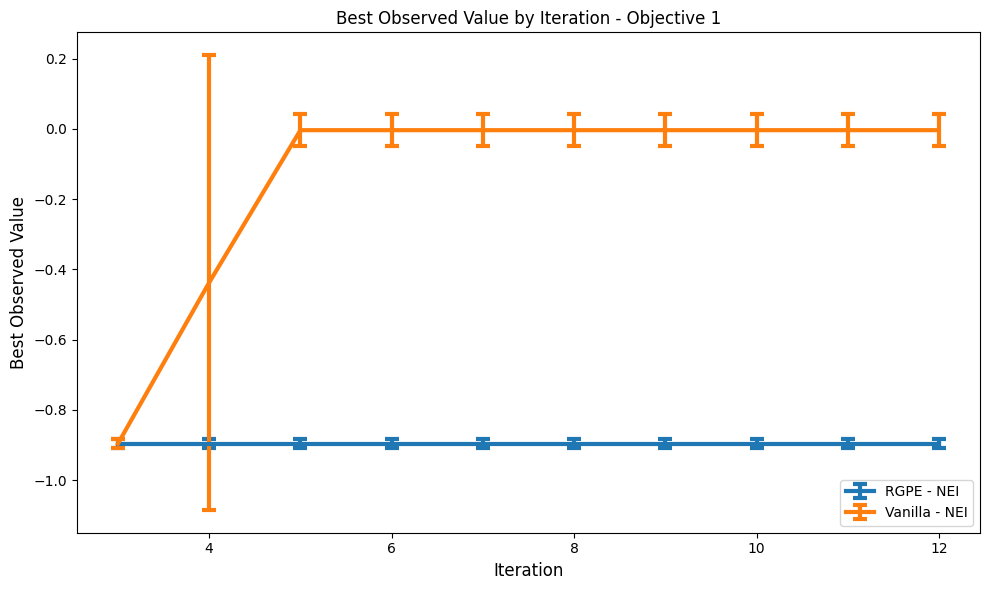

In [60]:
import numpy as np

best_rgpe_all_1 = np.array(best_rgpe_all_1)
best_vanilla_nei_all_1 = np.array(best_vanilla_nei_all_1)

x = range(RANDOM_INITIALIZATION_SIZE, RANDOM_INITIALIZATION_SIZE + N_BATCH)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
# Plot RGPE - NEI
ax.errorbar(
    x,
    best_rgpe_all_1.mean(axis=0),
    yerr=1.96 * best_rgpe_all_1.std(axis=0) / math.sqrt(N_TRIALS),
    label="RGPE - NEI",
    linewidth=3,
    capsize=5,
    capthick=3,
)
# Plot vanilla - NEI
ax.errorbar(
    x,
    best_vanilla_nei_all_1.mean(axis=0),
    yerr=1.96 * best_vanilla_nei_all_1.std(axis=0) / math.sqrt(N_TRIALS),
    label="Vanilla - NEI",
    linewidth=3,
    capsize=5,
    capthick=3,
)

# ax.set_ylim(bottom=0)
ax.set_xlabel("Iteration", fontsize=12)
ax.set_ylabel("Best Observed Value", fontsize=12)
ax.set_title("Best Observed Value by Iteration - Objective 1", fontsize=12)
ax.legend(loc="lower right", fontsize=10)
plt.tight_layout()

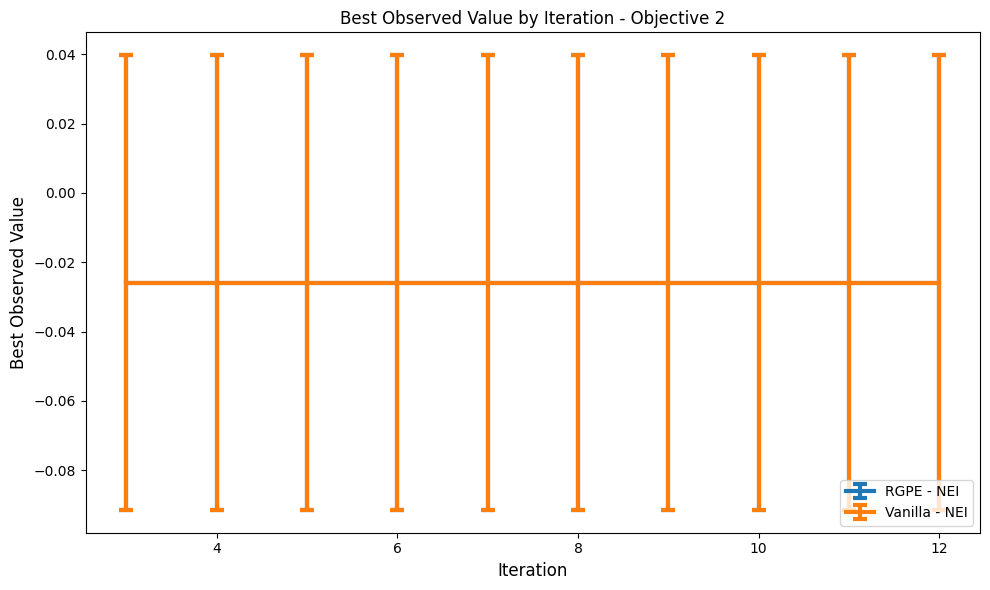

In [61]:
import numpy as np

best_rgpe_all_2 = np.array(best_rgpe_all_2)
best_vanilla_nei_all_2 = np.array(best_vanilla_nei_all_2)

x = range(RANDOM_INITIALIZATION_SIZE, RANDOM_INITIALIZATION_SIZE + N_BATCH)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
# Plot RGPE - NEI
ax.errorbar(
    x,
    best_rgpe_all_2.mean(axis=0),
    yerr=1.96 * best_rgpe_all_2.std(axis=0) / math.sqrt(N_TRIALS),
    label="RGPE - NEI",
    linewidth=3,
    capsize=5,
    capthick=3,
)
# Plot vanilla - NEI
ax.errorbar(
    x,
    best_vanilla_nei_all_2.mean(axis=0),
    yerr=1.96 * best_vanilla_nei_all_2.std(axis=0) / math.sqrt(N_TRIALS),
    label="Vanilla - NEI",
    linewidth=3,
    capsize=5,
    capthick=3,
)

# ax.set_ylim(bottom=0)
ax.set_xlabel("Iteration", fontsize=12)
ax.set_ylabel("Best Observed Value", fontsize=12)
ax.set_title("Best Observed Value by Iteration - Objective 2", fontsize=12)
ax.legend(loc="lower right", fontsize=10)
plt.tight_layout()

# # Plot model weights versus iterations

In [62]:
import torch
import matplotlib.pyplot as plt

# Given list of tensors

tensor_list=rank_weights_all_1

def extract_all_columns_mean_std(tensor_list):
    # Determine the number of columns
    num_columns = len(tensor_list[0][0])
    
    # Initialize lists to hold mean and std tensors for each column
    means = []
    stds = []
    
    for column_index in range(num_columns):
        # Extract the specified column from each tensor in each element of the tensor list
        columns = [torch.tensor([t[column_index] for t in element], dtype=torch.float64) for element in tensor_list]
        
        # Stack columns to create a 2D tensor
        stacked_columns = torch.stack(columns)
        
        # Calculate the mean element-wise
        mean_tensor = torch.mean(stacked_columns, dim=0)
        
        # Calculate the standard deviation element-wise
        std_tensor = torch.std(stacked_columns, dim=0)
        
        # Append to the lists
        means.append(mean_tensor)
        stds.append(std_tensor)
    
    return means, stds

# Calculate mean and standard deviation for all columns
means, stds = extract_all_columns_mean_std(tensor_list)

plt.figure(figsize=(14, 8))

for i, (mean_tensor, std_tensor) in enumerate(zip(means, stds)):
    label = f'Model {i+1}' if i < len(means) - 1 else 'Target model'
    plt.errorbar(iterations, mean_tensor.numpy(), yerr=std_tensor.numpy(), 
                 label=label, marker='o', capsize=5)

plt.xlabel('Iterations')
plt.ylabel('Values')
plt.title('Mean and Standard Deviation of Each Model Across Iterations - Objective 1')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'iterations' is not defined

<Figure size 1400x800 with 0 Axes>

In [ ]:
import torch
import matplotlib.pyplot as plt

# Given list of tensors

tensor_list=rank_weights_all_2

def extract_all_columns_mean_std(tensor_list):
    # Determine the number of columns
    num_columns = len(tensor_list[0][0])
    
    # Initialize lists to hold mean and std tensors for each column
    means = []
    stds = []
    
    for column_index in range(num_columns):
        # Extract the specified column from each tensor in each element of the tensor list
        columns = [torch.tensor([t[column_index] for t in element], dtype=torch.float64) for element in tensor_list]
        
        # Stack columns to create a 2D tensor
        stacked_columns = torch.stack(columns)
        
        # Calculate the mean element-wise
        mean_tensor = torch.mean(stacked_columns, dim=0)
        
        # Calculate the standard deviation element-wise
        std_tensor = torch.std(stacked_columns, dim=0)
        
        # Append to the lists
        means.append(mean_tensor)
        stds.append(std_tensor)
    
    return means, stds

# Calculate mean and standard deviation for all columns
means, stds = extract_all_columns_mean_std(tensor_list)

plt.figure(figsize=(14, 8))

for i, (mean_tensor, std_tensor) in enumerate(zip(means, stds)):
    label = f'Model {i+1}' if i < len(means) - 1 else 'Target model'
    plt.errorbar(iterations, mean_tensor.numpy(), yerr=std_tensor.numpy(), 
                 label=label, marker='o', capsize=5)

plt.xlabel('Iterations')
plt.ylabel('Values')
plt.title('Mean and Standard Deviation of Each Model Across Iterations - Objective 2')
plt.legend()
plt.grid(True)
plt.show()